# 2022.3.31

In [1]:
DATASET = "../dataset/MMS.csv"
TOPOLOGY = "../dataset/MMS_topology.pk"
RESULT="../topomad-1-results/MMS_GAT"
NAME="performance_evaluation_GAT"

In [2]:
import pandas as pd
from graph_lstm_vae_ad_faster import GraphLSTM_VAE_AD
from graph_lstm_vae_ad_faster import GraphLSTM_VAE
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import numpy as np
import os
import pickle
import time
import torch
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_choice =0

# 读数据

In [3]:
data = pd.read_csv(DATASET, header=[0,1])

# 参数

In [4]:
seq_len = 10
num_epo = 150
hid_dim = 3
lea_rat = 1e-4
nod_num = 50
sam_num = 20
del_tol = 5
tra_siz = len(data)//3*2

# 预处理标准化

In [5]:
metric = data.drop(['TimeStamp', 'label'], axis = 1)
metric.columns.names = ['pod','metric']
tempm = metric.swaplevel('metric','pod',axis=1).stack()
tempm = (tempm-tempm.mean())/(tempm.std())
metric = tempm.unstack().swaplevel('metric','pod',axis=1).stack().unstack()

/home/user/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


# 读拓扑

In [6]:
with open(TOPOLOGY, 'rb') as f:
    edge_index = pickle.load(f)

# 训练VAE

Epoch [150/150], Iter [60/63], total_loss: -3139.9795, recon_loss: -3251.1792, kl_loss: 111.1997
valid_loss: [1797.2425220630787, 1792.7706344039352, 1794.1688006365741, 1796.021701388889, 1791.7787407769097, 1791.3928900824653, 1791.4117250795719, 1787.3687789351852, 1774.737765842014, 1757.5021656177662, 1735.7508770978009, 1700.36456072772, 1657.8076669198495, 1598.8004421657986, 1534.607132523148, 1464.7627179181134, 1393.8099591290509, 1318.2068549262153, 1241.9591200086807, 1167.203547724971, 1088.9635484483506, 1021.0960806387442, 951.195246943721, 881.5971498842592, 811.7305207429109, 745.710139521846, 683.5525625723379, 617.8870759186922, 555.2191648130064, 495.01986355251734, 432.7162939001013, 376.3482315628617, 318.09761103877315, 259.3723104971427, 204.5432691220884, 147.08499484592014, 95.11597866482205, 39.608976929276075, -11.23226766233091, -60.956920835706924, -115.09814862851744, -165.38826553909868, -212.9390174018012, -259.55972177010995, -308.5170581958912, -353.0

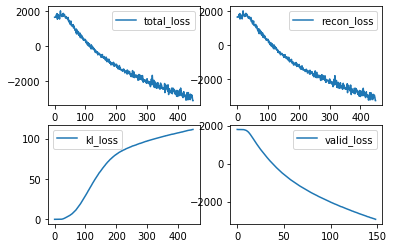

100%|██████████| 27/27 [00:04<00:00,  6.69it/s]
/home/user/hzl/bishe-mms/faster/graph_lstm_vae_ad_faster/graphlstm_vae_ad.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.interpolate(inplace=True)
/home/user/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
100%|██████████| 91/91 [04:11<00:00,  2.76s/it]
/home/user/hzl/bishe-mms/faster/graph_lstm_vae_ad_faster/graphlstm_vae_ad.py:312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

In [7]:
#checklist：ver，name，seedi，filename
from sklearn.metrics import average_precision_score
import pickle
aps = []
maps = []
traintime150s = []
testtimes = []
for seedi in range(5):
    model = GraphLSTM_VAE_AD(name=NAME+"VAE", sequence_length=seq_len, num_epochs=num_epo, hidden_dim=hid_dim, lr=lea_rat, gpu = gpu_choice, variational = True, kind = 'GAT',seed=seedi, head=(8,8),dropout=(0.4,0.4), bias=(True, False))
    traintime150_start=time.time()
    model.fit(metric[:tra_siz],nod_num, edge_index)
    traintime150_end=time.time()
    traintime150s.append(traintime150_end-traintime150_start)
    
    testtime_start=time.time()
    pred = model.predict(metric[tra_siz:],nod_num, edge_index, sam_num, del_tol)[1]
    testtime_end=time.time()
    testtimes.append(testtime_end-testtime_start)
    
    
    pred_t = model.predict(metric[:tra_siz], nod_num, edge_index, sam_num, del_tol)[1]
    itp=model.interpret(metric[tra_siz:],nod_num, edge_index, sam_num, del_tol)
    
    ap = average_precision_score(data['label'][tra_siz+seq_len-del_tol:],pred)
    aps.append(ap)
    
    mapp = np.mean((average_precision_score(data['label'][tra_siz+seq_len-del_tol:],pred), average_precision_score(1-data['label'][tra_siz+seq_len-del_tol:],-pred)))
    maps.append(mapp)

In [8]:
print(aps)
print(maps)

[0.44546379299195243, 0.446228654079362, 0.4429879274242494, 0.4463454411725116, 0.445277909737149]
[0.7010292781148034, 0.7013511990329346, 0.7001372768209961, 0.7011541733236337, 0.7004709792910512]


In [9]:
np.mean(maps)

0.7008285813166838

In [10]:
np.mean(aps)

0.4452607450810449

In [11]:
print(traintime150s)

[3732.759813785553, 3788.3246517181396, 3635.5087356567383, 3523.102861881256, 3559.9291837215424]


In [12]:
np.mean(traintime150s)/60

60.7987508225441